In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
import sklearn.preprocessing

In [3]:
# dataframe display 옵션
pd.set_option('display.max_columns' , 30)
pd.set_option('display.width', None)

In [4]:
data = pd.read_csv('./data/final1_Data.csv')
train_df, test_df = train_test_split(data, train_size = 0.7)

In [5]:
## 메모리 절약
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

In [7]:
# null값 확인 및 
# inplace=False로 하면 기존 혹은 새로운 변수에 할당해야 하고, inplace = True 하면 해당변수에 적용됨
# na가 포함된 행을 제거하는 것은 데이터 소실이 크기 때문에 inplace=False가 default
train_df.dropna(inplace = True)
print(train_df.isnull().any().any())
test_df.dropna(inplace = True)
print(test_df.isnull().any().any())

False
False


In [136]:
other_train_df = train_df[(train_df['matchType'] == 2)]
other_test_df = test_df[(test_df['matchType'] == 2)]

In [137]:
other_train_df.columns

Index(['Id', 'assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'kills',
       'killStreaks', 'longestKill', 'matchType', 'revives', 'rideDistance',
       'swimDistance', 'walkDistance', 'weaponsAcquired', 'longestKill_log',
       'rideDistance_log', 'swimDistance_log', 'walkDistance_log',
       'headshotKillrate', 'winPlacePerc'],
      dtype='object')

In [138]:
del_list = ['longestKill', 'rideDistance',
       'swimDistance', 'walkDistance', 'headshotKills','DBNOs','killStreaks']
for col in del_list:
    del other_train_df[col] # 한 번만 실행
    del other_test_df[col] # 한 번만 실행

In [142]:
total_ncol = len(other_train_df.columns)

train_np = np.array(other_train_df)
test_np = np.array(other_test_df)

# 데이터 전 처리. 표준졍규화 값으로 스케일링.
# scaler = sklearn.preprocessing.StandardScaler()

x_train = (train_np[:,1:-1]) # fit : 표준화하기 위한 평균과 분산을 구하기 위함
y_train = train_np[:,[-1]]
print('pass')

x_test = (test_np[:,1:-1]) # id, groupId, matchid 제외
y_test = test_np[:,[-1]]
print('pass')

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, total_ncol-2]) # id, winplaceperc 제외
Y = tf.placeholder(tf.float32, shape=[None, 1])
dropout_rate = tf.placeholder(tf.float32)

# initilizing Weights - xavier_initializer()
initializer = tf.contrib.layers.xavier_initializer()

W1 = tf.Variable(initializer([total_ncol-2, 10]))
b1 = tf.Variable(initializer([10]))
_layer1 = tf.nn.leaky_relu(tf.matmul(X, W1) + b1)
layer1 = tf.nn.dropout(_layer1,dropout_rate)
# drop out - overfitting 문제 방지, 랜덤하게 뉴런을 kill해버림

# W1 = tf.Variable(tf.random_normal([total_ncol-2, 10]), name='weight1')
# b1 = tf.Variable(tf.random_normal([10]), name='bias1')
# layer1 = tf.nn.leaky_relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(initializer([10, 10]))
b2 = tf.Variable(initializer([10]))
_layer2 = tf.nn.leaky_relu(tf.matmul(layer1, W2) + b2)
layer2 = tf.nn.dropout(_layer2,dropout_rate)

W3 = tf.Variable(initializer([10, 10]))
b3 = tf.Variable(initializer([10]))
_layer3 = tf.nn.leaky_relu(tf.matmul(layer2, W3) + b3)
layer3 = tf.nn.dropout(_layer3,dropout_rate)

W4 = tf.Variable(initializer([10, 1]))
b4 = tf.Variable(initializer([1]))
_hypothesis = tf.nn.leaky_relu(tf.matmul(layer3, W4) + b4) # 마지막은 sigmoid? 0~1사이값
hypothesis = tf.nn.dropout(_hypothesis,dropout_rate)

# cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y)) 
train = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)

# Launch the graph in a session.
with tf.Session() as sess:
    # Initializes global variables in the graph.
    sess.run(tf.global_variables_initializer())
    batch_size=10000
    total_batch = int(len(x_train)/batch_size)
    
    for epoch in tqdm_notebook(range(130)):
        total_cost = 0
        
        for step, offset in enumerate(range(0, len(x_train)+1, batch_size)):
            x_batch, y_batch = x_train[offset: offset + batch_size], y_train[offset: offset + batch_size]  
            cost_val, hy_val, _ = sess.run(
                [cost, hypothesis, train], feed_dict={X: x_batch, Y: y_batch, dropout_rate:1 })
            total_cost += cost_val
            
        print('Epoch: ', '%04d' % (epoch+1), 'Avg.cost = ', '{:.3f}'.format(total_cost/total_batch))
#             if step % 1000 == 0:
#                 print(step, "Cost: ", cost_val, "\nPrediction:\n", hy_val)
#     Weight = sess.run(W)
#     print("W\t" , Weight)
    y_predict = sess.run(hypothesis, feed_dict={X:x_test,dropout_rate:1})
    print("Predict\t", y_predict)

pass
pass


Epoch:  0001 Avg.cost =  1374.373
Epoch:  0002 Avg.cost =  257.515
Epoch:  0003 Avg.cost =  214.409
Epoch:  0004 Avg.cost =  198.406
Epoch:  0005 Avg.cost =  186.035
Epoch:  0006 Avg.cost =  176.558
Epoch:  0007 Avg.cost =  169.778
Epoch:  0008 Avg.cost =  165.406
Epoch:  0009 Avg.cost =  162.826
Epoch:  0010 Avg.cost =  161.274
Epoch:  0011 Avg.cost =  160.282
Epoch:  0012 Avg.cost =  159.645
Epoch:  0013 Avg.cost =  159.172
Epoch:  0014 Avg.cost =  158.745
Epoch:  0015 Avg.cost =  158.406
Epoch:  0016 Avg.cost =  158.177
Epoch:  0017 Avg.cost =  157.992
Epoch:  0018 Avg.cost =  157.836
Epoch:  0019 Avg.cost =  157.684
Epoch:  0020 Avg.cost =  157.528
Epoch:  0021 Avg.cost =  157.369
Epoch:  0022 Avg.cost =  157.208
Epoch:  0023 Avg.cost =  157.056
Epoch:  0024 Avg.cost =  156.926
Epoch:  0025 Avg.cost =  156.828
Epoch:  0026 Avg.cost =  156.737
Epoch:  0027 Avg.cost =  156.629
Epoch:  0028 Avg.cost =  156.519
Epoch:  0029 Avg.cost =  156.411
Epoch:  0030 Avg.cost =  156.308
Epoch:  0

In [143]:
test_id = pd.DataFrame(other_test_df['Id'])
test_winPlacePerc = pd.DataFrame(other_test_df['winPlacePerc'])
y_predict_df = pd.DataFrame(y_predict,index = test_id.index, columns=['predict'])
diff = pd.DataFrame(other_test_df['winPlacePerc']-y_predict_df['predict'],
                   columns=['diff'])

mae = sum(abs(diff['diff']))/diff['diff'].count() # Mean absolute error

result = pd.DataFrame({'Id':test_id['Id'],'winPlacePerc':test_winPlacePerc['winPlacePerc'], 
                       'predict':y_predict_df['predict'],'diff':diff['diff'],'MAE':mae})
# result.to_csv("./result/final_1/final1_duo_NN_layer3_sigmoid.csv", sep=',', encoding='utf-8')
print(result.head())
print('Mae\t : ', mae)

                     Id  winPlacePerc   predict      diff       MAE
1087761  8adbac7266b486      0.021698  0.135290 -0.113592  0.090559
1571916  e320a29cbdf592      0.395752  0.278207  0.117545  0.090559
1147032  add008c63ca8e9      0.638184  0.573016  0.065168  0.090559
1586486  879af2227bdcef      0.680664  0.772820 -0.092156  0.090559
1346520  b3354ba3517f04      0.630371  0.535060  0.095311  0.090559
Mae	 :  0.09055876171741141


### kaggle 50 rank mse : 0.0207... we have to go further

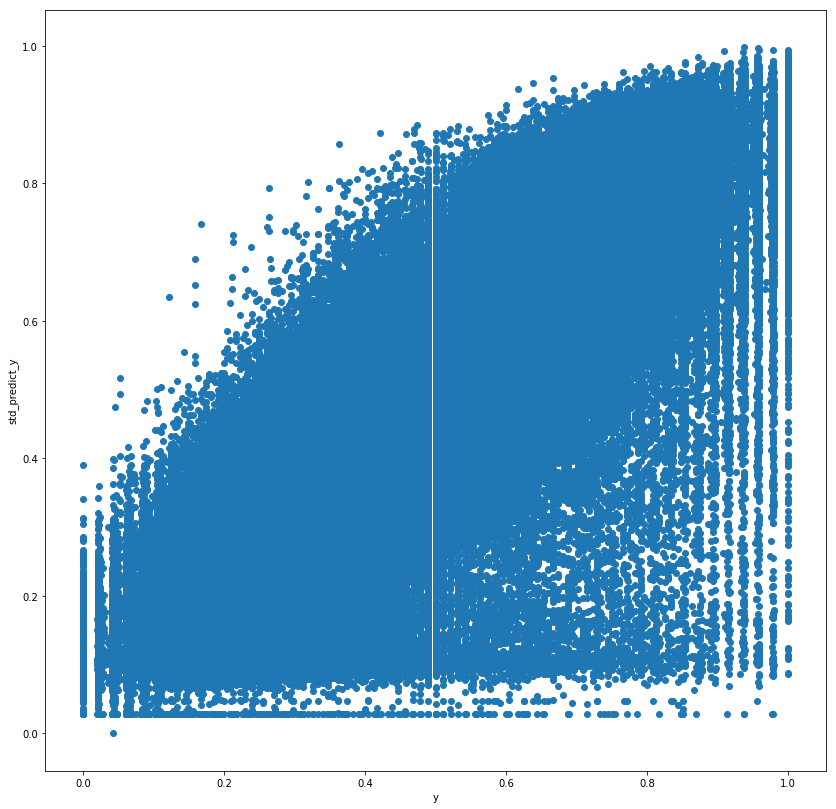

In [144]:
f, ax = plt.subplots(figsize=(14, 14))
plt.scatter(result['winPlacePerc'], result['predict'])
plt.xlabel("y")
plt.ylabel("std_predict_y")
# plt.savefig("./graph/final_1/final1_duo_NN_layer3_sigmoid.png")
plt.show()

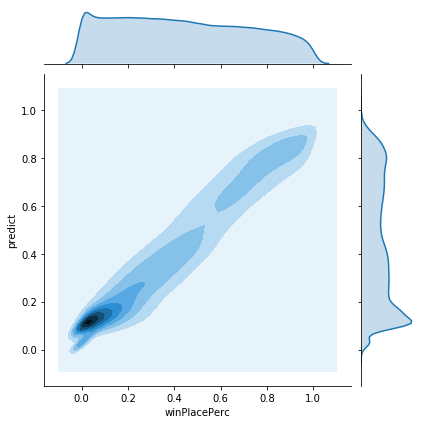

In [145]:
# 회귀분석은 1의값은 예측을 잘하지만, 가운데 값과 0의 값은 예측을 잘하지 못함
sns_plot = sns.jointplot(x= 'winPlacePerc', y= 'predict', data=result, kind='kde')
sns_plot.savefig("./graph/final_1/final1_duo_NN_layer3.png")